In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/709/Ass2/

/content/drive/MyDrive/709/Ass2


In [3]:
ls

 gold1.csv/          gold.csv   spark-warehouse/  ' Task 2.ipynb'  'Task3 test 1.ipynb'
 gold1_single.csv/   models/   'Task 1.ipynb'     'Task 3.ipynb'    Untitled0.ipynb


In [4]:
# Step 1- install libaray

import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml import Estimator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import warnings

# Breakdown sections

In [5]:
# Initialize Spark session with memory configuration
spark = SparkSession.builder \
    .appName("GoldPricePrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load and preprocess the dataset
df = spark.read.csv("gold1.csv", header=True, inferSchema=True)

# Check the schema to verify data types and make adjustments if needed
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- PriceRange: double (nullable = true)
 |-- LogReturn: double (nullable = true)
 |-- DailyChange%: double (nullable = true)
 |-- ShortMA: double (nullable = true)
 |-- LongMA: double (nullable = true)
 |-- Volatility: double (nullable = true)
 |-- DayOfWeek: string (nullable = true)



In [6]:
# Check for null values
from pyspark.sql.functions import count, when, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+
|Date|Open|High|Low|Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA|LongMA|Volatility|DayOfWeek|
+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+
|   0|   0|   0|  0|    0|     0|         0|        0|           0|      0|     0|         0|        0|
+----+----+----+---+-----+------+----------+---------+------------+-------+------+----------+---------+



 Feature Engineering

In [7]:
# Define the custom mapping dictionary

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

day_mapping = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

# Define the UDF to apply the mapping
def map_day_to_index(day):
    return day_mapping.get(day, -1)  # Return -1 for any unexpected value

# Register the UDF
map_day_udf = udf(map_day_to_index, IntegerType())

# Apply the UDF to the DataFrame
df = df.withColumn("DayOfWeek_index", map_day_udf(df["DayOfWeek"]))

# Show the result
df.select("DayOfWeek", "DayOfWeek_index").show(5)


+---------+---------------+
|DayOfWeek|DayOfWeek_index|
+---------+---------------+
|  Tuesday|              1|
|Wednesday|              2|
| Thursday|              3|
|   Friday|              4|
|   Monday|              0|
+---------+---------------+
only showing top 5 rows



In [8]:
df.show(10)

+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+---------------+
|      Date| Open| High|  Low|Close|Volume|PriceRange|LogReturn|DailyChange%|ShortMA|LongMA|Volatility|DayOfWeek|DayOfWeek_index|
+----------+-----+-----+-----+-----+------+----------+---------+------------+-------+------+----------+---------+---------------+
|2000-01-04|289.5|289.5|280.0|283.7| 21621|       9.5|      0.0|         0.0|  283.7| 283.7|       0.0|  Tuesday|              1|
|2000-01-05|283.7|285.0|281.0|282.1| 25448|       4.0| -0.00566|       -0.56|  282.9| 282.9|      1.13|Wednesday|              2|
|2000-01-06|281.6|282.8|280.2|282.4| 19055|       2.6|  0.00106|        0.11| 282.73|282.73|      0.85| Thursday|              3|
|2000-01-07|282.5|284.5|282.0|282.9| 11266|       2.5|  0.00177|        0.18| 282.78|282.78|       0.7|   Friday|              4|
|2000-01-10|282.4|283.9|281.8|282.7| 30603|       2.1|  -7.1E-4|       -0.07| 282.76|282.7

In [9]:
# Define the feature columns (excluding 'Close' as the target variable)

feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn", "DailyChange%", "ShortMA", "LongMA", "Volatility", "DayOfWeek_index"]

# Combine the features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the scaled features (scaled 'features' vector column)
df.select("scaled_features").show(5)



+--------------------+
|     scaled_features|
+--------------------+
|[0.55815817314225...|
|[0.54697572960434...|
|[0.54292691384062...|
|[0.54466212059650...|
|[0.54446931984585...|
+--------------------+
only showing top 5 rows



In [10]:
# Apply PCA

from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)
df = pca_model.transform(df)

# Show the first few PCA components
df.select("pca_features").show(5)


+--------------------+
|        pca_features|
+--------------------+
|[-1.3153839380368...|
|[-1.2402692379639...|
|[-1.1650189075271...|
|[-1.1408977496569...|
|[-1.1908740871510...|
+--------------------+
only showing top 5 rows



In [11]:
# Get PCA coefficients (loadings)
pca_coefficients = pca_model.pc.toArray()

# Create a DataFrame to view the PCA coefficients
coeff_df = pd.DataFrame(pca_coefficients)

# Display the coefficients
print(coeff_df)

           0         1         2         3         4
0  -0.385669 -0.022989 -0.025264  0.190763 -0.004983
1  -0.386056 -0.029312 -0.023921  0.179725 -0.005278
2  -0.384859 -0.031671 -0.026565  0.203445 -0.003907
3  -0.296002  0.027951  0.089152 -0.260913  0.769484
4  -0.271811  0.072826  0.086868 -0.799623 -0.055395
5   0.018691 -0.703618 -0.008174 -0.059377  0.019143
6   0.018170 -0.703332 -0.006886 -0.069768  0.019458
7  -0.385342 -0.023165 -0.025343  0.195266 -0.014276
8  -0.382649 -0.023994 -0.026769  0.213865 -0.011108
9  -0.311472 -0.011188 -0.008339 -0.277109 -0.631445
10 -0.001545 -0.023079  0.990478  0.115745 -0.070450


In [12]:
# Get the explained variance (variance explained by each principal component)
explained_variance = pca_model.explainedVariance
print(f"Explained Variance for each principal component: {explained_variance}")


Explained Variance for each principal component: [0.5927149004583592,0.18271092342992448,0.09147929608747711,0.061528787059589675,0.0482237006197088]


In [13]:
# Get PCA coefficients (loadings)
pca_coefficients = pca_model.pc.toArray()

# Convert the coefficients into a DataFrame for easier visualization
import pandas as pd

# Create a DataFrame where each row is a feature and each column is a principal component
coeff_df = pd.DataFrame(pca_coefficients, columns=[f'PC{i+1}' for i in range(pca_coefficients.shape[1])], index=feature_cols)

# Display the coefficients for each principal component
print(coeff_df)

# To identify which features have the highest loadings for each PC:
# For each principal component, sort the features based on the absolute value of the coefficient
for pc in coeff_df.columns:
    print(f"Top features for {pc}:")
    top_features = coeff_df[pc].abs().sort_values(ascending=False).head(5)  # Top 5 features by absolute value of coefficient
    print(top_features)

spark.stop()

                      PC1       PC2       PC3       PC4       PC5
Open            -0.385669 -0.022989 -0.025264  0.190763 -0.004983
High            -0.386056 -0.029312 -0.023921  0.179725 -0.005278
Low             -0.384859 -0.031671 -0.026565  0.203445 -0.003907
Volume          -0.296002  0.027951  0.089152 -0.260913  0.769484
PriceRange      -0.271811  0.072826  0.086868 -0.799623 -0.055395
LogReturn        0.018691 -0.703618 -0.008174 -0.059377  0.019143
DailyChange%     0.018170 -0.703332 -0.006886 -0.069768  0.019458
ShortMA         -0.385342 -0.023165 -0.025343  0.195266 -0.014276
LongMA          -0.382649 -0.023994 -0.026769  0.213865 -0.011108
Volatility      -0.311472 -0.011188 -0.008339 -0.277109 -0.631445
DayOfWeek_index -0.001545 -0.023079  0.990478  0.115745 -0.070450
Top features for PC1:
High       0.386056
Open       0.385669
ShortMA    0.385342
Low        0.384859
LongMA     0.382649
Name: PC1, dtype: float64
Top features for PC2:
LogReturn       0.703618
DailyChange% 

# Task3. Part A- Perform ML model selection and traning - Regressoin

Dataset loaded successfully.
Linear Regression RMSE:  34.396483287354286
Linear Regression R²:  0.9953237677475364
Random Forest RMSE:  91.1692282946073
Random Forest R²:  0.967147793377837
Decision Tree RMSE:  76.44789645384883
Decision Tree R²:  0.9769006867763347


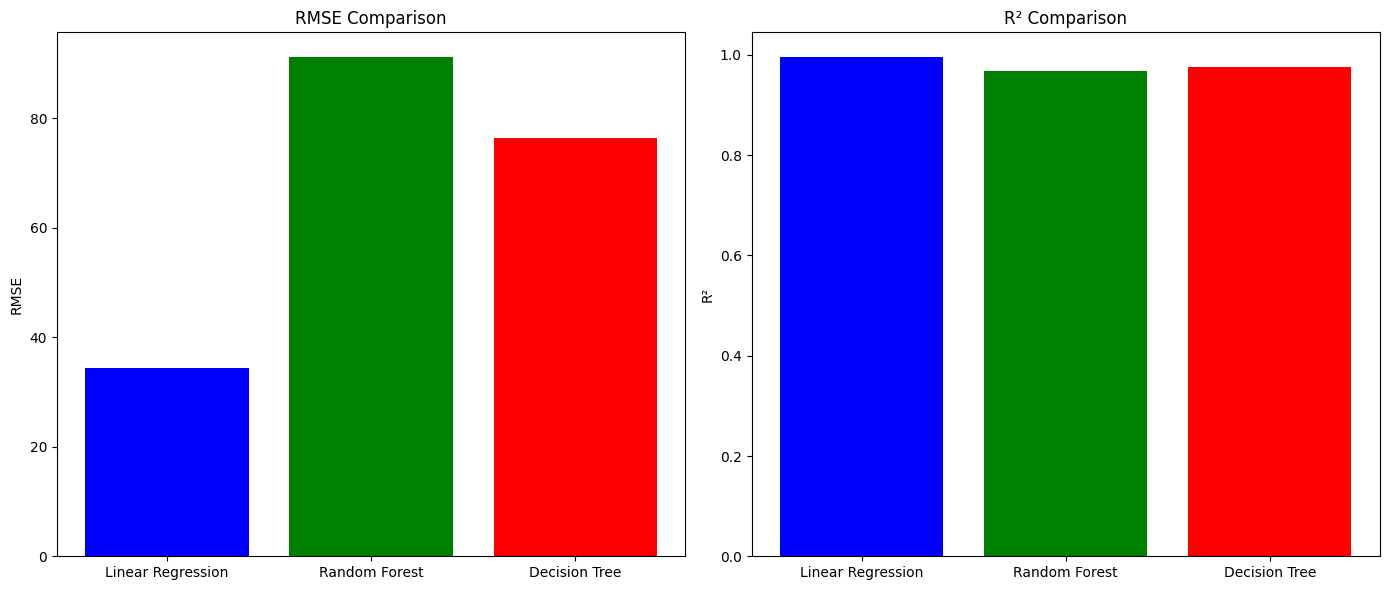

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session with memory configuration
spark = SparkSession.builder \
    .appName("GoldPricePrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load and preprocess the dataset
try:
    df = spark.read.csv("gold1.csv", header=True, inferSchema=True)
    if df.count() == 0:
        print("Warning: Dataframe is empty.")
    else:
        print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Ensure the column "DailyChange%" exists before proceeding
if "DailyChange%" in df.columns:

# Feature engineering: Map days of the week to numerical values
    day_mapping = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday": 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6
    }

    def map_day_to_index(day):
        return day_mapping.get(day, -1)

    map_day_udf = udf(map_day_to_index, IntegerType())
    df = df.withColumn("DayOfWeek_index", map_day_udf(df["DayOfWeek"]))

    # Now create the "Label" column
    df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))

else:
    print("Error: 'DailyChange%' column not found in the dataset.")


# Prepare features
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn", "DailyChange%", "ShortMA", "LongMA", "Volatility", "DayOfWeek_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")

# Define reusable pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[assembler, scaler, pca])

# Apply preprocessing pipeline
df = preprocessing_pipeline.fit(df).transform(df)

# Split the dataset into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 2: Train Linear Regression model
lr = LinearRegression(featuresCol="pca_features", labelCol="Close")
lr_model = lr.fit(train_df)

# Step 3: Train Random Forest model
rf = RandomForestRegressor(featuresCol="pca_features", labelCol="Close")
rf_model = rf.fit(train_df)

# Step 4: Train Decision Tree model
dt = DecisionTreeRegressor(featuresCol="pca_features", labelCol="Close")
dt_model = dt.fit(train_df)

# Step 5: Make predictions using Linear Regression model
lr_predictions = lr_model.transform(test_df)

# Step 6: Make predictions using Random Forest model
rf_predictions = rf_model.transform(test_df)

# Step 7: Make predictions using Decision Tree model
dt_predictions = dt_model.transform(test_df)

# Step 8: Evaluate Linear Regression model
lr_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
lr_r2 = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"})

# Step 9: Evaluate Random Forest model
rf_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
rf_r2 = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "r2"})

# Step 10: Evaluate Decision Tree model
dt_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
dt_rmse = dt_evaluator.evaluate(dt_predictions)
dt_r2 = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "r2"})

# Print the evaluation results for all models
print("Linear Regression RMSE: ", lr_rmse)
print("Linear Regression R²: ", lr_r2)
print("Random Forest RMSE: ", rf_rmse)
print("Random Forest R²: ", rf_r2)
print("Decision Tree RMSE: ", dt_rmse)
print("Decision Tree R²: ", dt_r2)

# Step 11: Visualize the results
# Collect the results in a Pandas DataFrame
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'RMSE': [lr_rmse, rf_rmse, dt_rmse],
    'R²': [lr_r2, rf_r2, dt_r2]
})

# Plot RMSE and R²
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# RMSE Bar Plot
ax[0].bar(metrics_df['Model'], metrics_df['RMSE'], color=['blue', 'green', 'red'])
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')

# R² Bar Plot
ax[1].bar(metrics_df['Model'], metrics_df['R²'], color=['blue', 'green', 'red'])
ax[1].set_title('R² Comparison')
ax[1].set_ylabel('R²')

plt.tight_layout()
plt.show()

# Stop Spark session
spark.stop()

# Task3. Part A- Perform ML model selection and traning - Classification

Dataset loaded successfully.
Logistic Regression AUC:  0.9999899472229203
Logistic Regression Accuracy:  0.9981718464351006
Random Forest AUC:  0.9993700259696742
Random Forest Accuracy:  0.9853747714808044
Decision Tree AUC:  0.9954661975370697
Decision Tree Accuracy:  0.9826325411334552


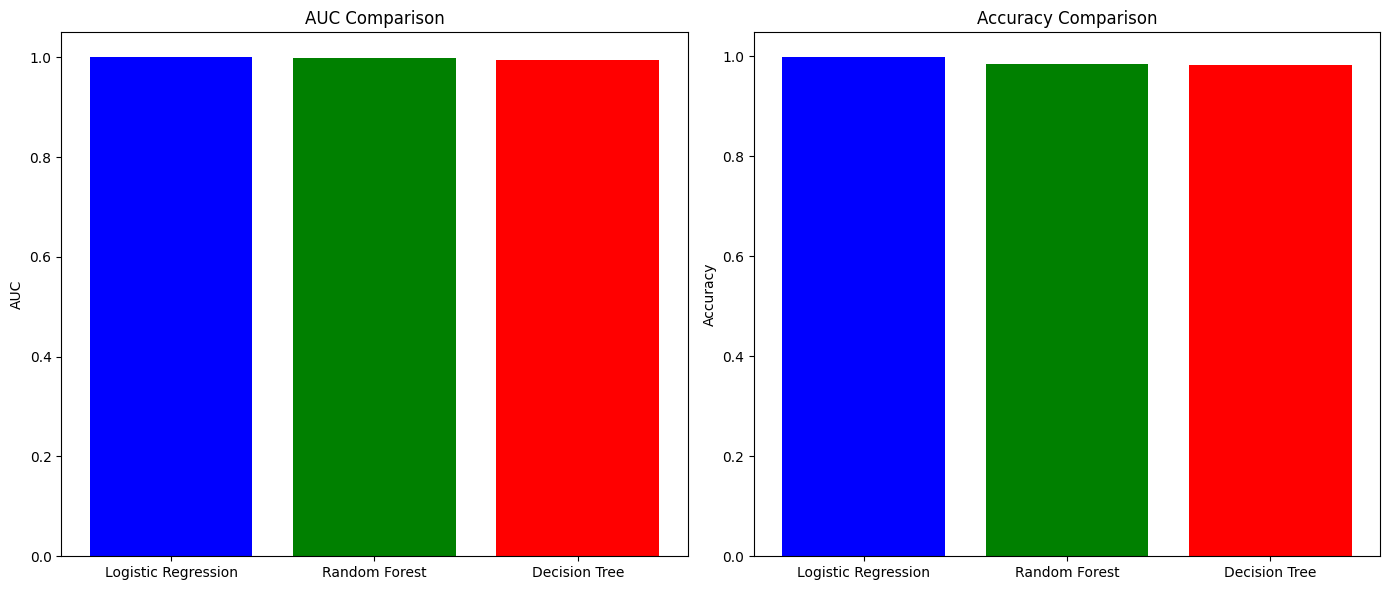

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd


# Initialize Spark session with memory configuration
spark = SparkSession.builder \
    .appName("GoldPricePrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load and preprocess the dataset
try:
    df = spark.read.csv("gold1.csv", header=True, inferSchema=True)
    if df.count() == 0:
        print("Warning: Dataframe is empty.")
    else:
        print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Ensure the column "DailyChange%" exists before proceeding
if "DailyChange%" in df.columns:

# Feature engineering: Map days of the week to numerical values
    day_mapping = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday": 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6
    }

    def map_day_to_index(day):
        return day_mapping.get(day, -1)

    map_day_udf = udf(map_day_to_index, IntegerType())
    df = df.withColumn("DayOfWeek_index", map_day_udf(df["DayOfWeek"]))

    # Now create the "Label" column
    df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))

else:
    print("Error: 'DailyChange%' column not found in the dataset.")


# Prepare features
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn", "DailyChange%", "ShortMA", "LongMA", "Volatility", "DayOfWeek_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")

# Define reusable pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[assembler, scaler, pca])

# Apply preprocessing pipeline
df = preprocessing_pipeline.fit(df).transform(df)

# Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 1: Define classification label
df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))  # Label 1 for increase, 0 for decrease

# Split the dataset into training and testing sets (you can use the same split or define a new one)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 2: Train Logistic Regression model for classification
lr_classifier = LogisticRegression(featuresCol="pca_features", labelCol="Label")
lr_classifier_model = lr_classifier.fit(train_df)

# Step 3: Train Random Forest Classifier model
rf_classifier = RandomForestClassifier(featuresCol="pca_features", labelCol="Label")
rf_classifier_model = rf_classifier.fit(train_df)

# Step 4: Train Decision Tree Classifier model
dt_classifier = DecisionTreeClassifier(featuresCol="pca_features", labelCol="Label")
dt_classifier_model = dt_classifier.fit(train_df)

# Step 5: Make predictions using Logistic Regression model
lr_predictions = lr_classifier_model.transform(test_df)

# Step 6: Make predictions using Random Forest Classifier model
rf_predictions = rf_classifier_model.transform(test_df)

# Step 7: Make predictions using Decision Tree Classifier model
dt_predictions = dt_classifier_model.transform(test_df)

# Step 8: Evaluate Logistic Regression model
lr_evaluator = BinaryClassificationEvaluator(labelCol="Label")
lr_auc = lr_evaluator.evaluate(lr_predictions)
lr_accuracy = lr_predictions.filter(lr_predictions["Label"] == lr_predictions["prediction"]).count() / float(lr_predictions.count())

# Step 9: Evaluate Random Forest Classifier model
rf_evaluator = BinaryClassificationEvaluator(labelCol="Label")
rf_auc = rf_evaluator.evaluate(rf_predictions)
rf_accuracy = rf_predictions.filter(rf_predictions["Label"] == rf_predictions["prediction"]).count() / float(rf_predictions.count())

# Step 10: Evaluate Decision Tree Classifier model
dt_evaluator = BinaryClassificationEvaluator(labelCol="Label")
dt_auc = dt_evaluator.evaluate(dt_predictions)
dt_accuracy = dt_predictions.filter(dt_predictions["Label"] == dt_predictions["prediction"]).count() / float(dt_predictions.count())

# Print the evaluation results for all models
print("Logistic Regression AUC: ", lr_auc)
print("Logistic Regression Accuracy: ", lr_accuracy)
print("Random Forest AUC: ", rf_auc)
print("Random Forest Accuracy: ", rf_accuracy)
print("Decision Tree AUC: ", dt_auc)
print("Decision Tree Accuracy: ", dt_accuracy)

# Step 11: Visualize the results
# Collect the results in a Pandas DataFrame
metrics_df_classification = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree'],
    'AUC': [lr_auc, rf_auc, dt_auc],
    'Accuracy': [lr_accuracy, rf_accuracy, dt_accuracy]
})

# Plot AUC and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# AUC Bar Plot
ax[0].bar(metrics_df_classification['Model'], metrics_df_classification['AUC'], color=['blue', 'green', 'red'])
ax[0].set_title('AUC Comparison')
ax[0].set_ylabel('AUC')

# Accuracy Bar Plot
ax[1].bar(metrics_df_classification['Model'], metrics_df_classification['Accuracy'], color=['blue', 'green', 'red'])
ax[1].set_title('Accuracy Comparison')
ax[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Stop Spark session
spark.stop()



# Task3. Part A- Perform linear regression  and classification Hyperparameter and model Evaluation

Dataset loaded successfully.
Regression Model: Linear Regression, RMSE: 34.3961, R²: 0.9953
Regression Model: Random Forest Regressor, RMSE: 52.4545, R²: 0.9891
Regression Model: Decision Tree Regressor, RMSE: 55.1853, R²: 0.9880
Classification Model: Logistic Regression, Accuracy: 0.9945
Confusion Matrix:
[[517   2]
 [  4 571]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       519
         1.0       1.00      0.99      0.99       575

    accuracy                           0.99      1094
   macro avg       0.99      0.99      0.99      1094
weighted avg       0.99      0.99      0.99      1094

Classification Model: Random Forest Classifier, Accuracy: 0.9899
Confusion Matrix:
[[515   4]
 [  7 568]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       519
         1.0       0.99      0.99      0.99       575

    accuracy              

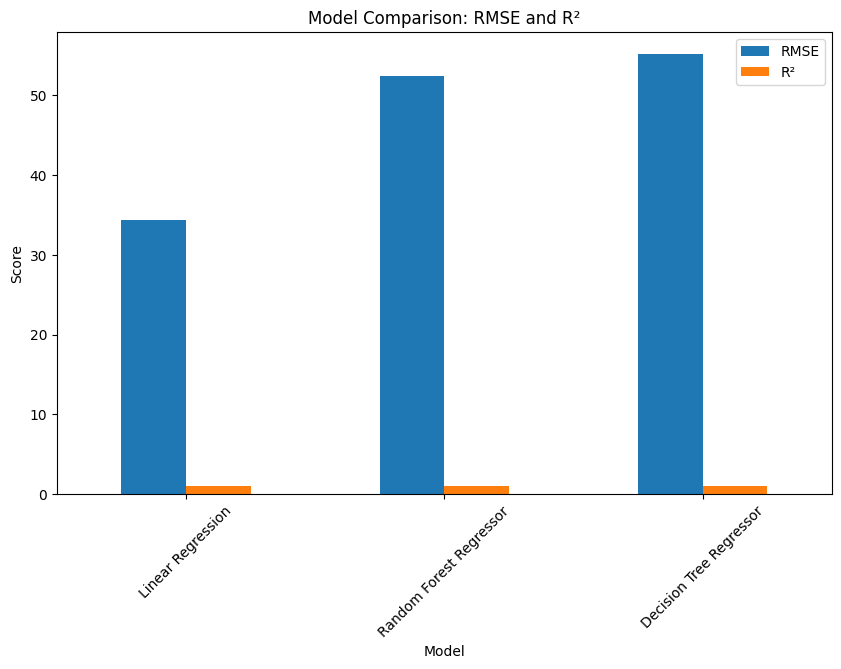

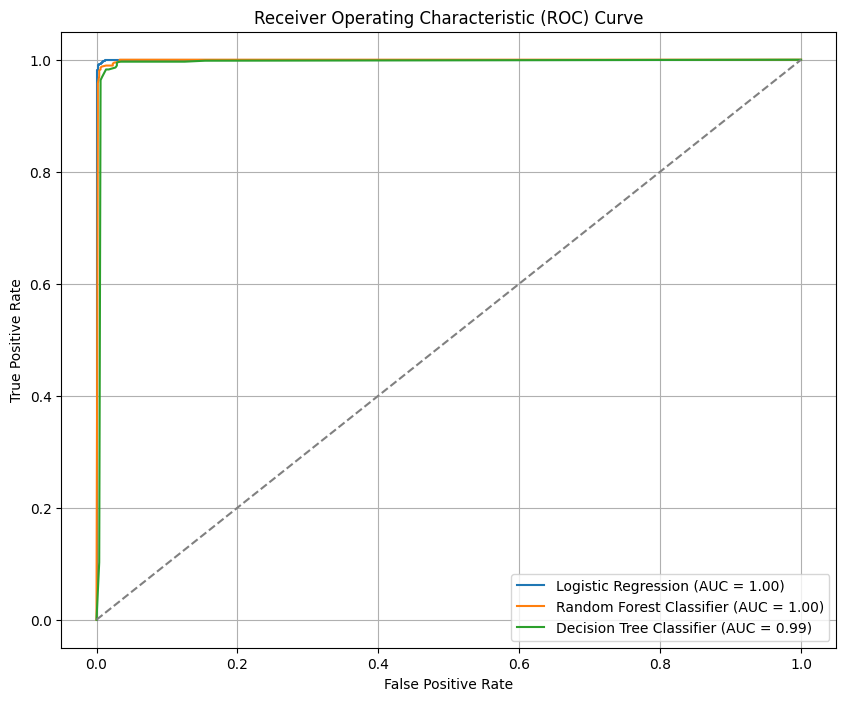

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Spark session
spark = SparkSession.builder \
    .appName("GoldPricePrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load and preprocess the dataset
try:
    df = spark.read.csv("gold1.csv", header=True, inferSchema=True)
    if df.count() == 0:
        print("Warning: Dataframe is empty.")
    else:
        print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Ensure the column "DailyChange%" exists before proceeding
if "DailyChange%" in df.columns:

# Feature engineering: Map days of the week to numerical values
    day_mapping = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday": 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6
    }

    def map_day_to_index(day):
        return day_mapping.get(day, -1)

    map_day_udf = udf(map_day_to_index, IntegerType())
    df = df.withColumn("DayOfWeek_index", map_day_udf(df["DayOfWeek"]))

    # Now create the "Label" column
    df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))

else:
    print("Error: 'DailyChange%' column not found in the dataset.")


# Prepare features
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn", "DailyChange%", "ShortMA", "LongMA", "Volatility", "DayOfWeek_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")

# Define reusable pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[assembler, scaler, pca])

# Apply preprocessing pipeline
df = preprocessing_pipeline.fit(df).transform(df)

# Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ------------------- Regression Task -------------------
regression_models = {
    "Linear Regression": LinearRegression(featuresCol="pca_features", labelCol="Close"),
    "Random Forest Regressor": RandomForestRegressor(featuresCol="pca_features", labelCol="Close"),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol="pca_features", labelCol="Close")
}

# Function to build pipeline for each regression model
def build_regression_pipeline(model):
    return Pipeline(stages=[model])

# Evaluate regression models
regression_results = []
for model_name, model in regression_models.items():
    # Hyperparameter tuning
    if model_name == "Linear Regression":
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()
    elif model_name == "Random Forest Regressor":
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.numTrees, [10, 20]) \
            .build()
    elif model_name == "Decision Tree Regressor":
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

    # Cross-validation
    pipeline = build_regression_pipeline(model)
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse"),
                              numFolds=5)
    cv_model = crossval.fit(train_df)

    # Evaluate the model
    best_model = cv_model.bestModel
    predictions = best_model.transform(test_df)
    rmse = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse").evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2").evaluate(predictions)

    regression_results.append({"Model": model_name, "RMSE": rmse, "R²": r2})

# ------------------- Classification Task -------------------
df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))
classification_models = {
    "Logistic Regression": LogisticRegression(featuresCol="pca_features", labelCol="Label"),
    "Random Forest Classifier ": RandomForestClassifier(featuresCol="pca_features", labelCol="Label"),
    "Decision Tree Classifier": DecisionTreeClassifier(featuresCol="pca_features", labelCol="Label")
}

# Function to build pipeline for each classification model
def build_classification_pipeline(model):
    return Pipeline(stages=[model])

# Evaluate classification models
classification_results = []
for model_name, model in classification_models.items():
    # Hyperparameter tuning
    if model_name == "Logistic Regression":
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()
    elif model_name == "Random Forest Classifier":
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.numTrees, [10, 20]) \
            .build()
    elif model_name == "Decision Tree Classifier":
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

    # Cross-validation
    pipeline = build_classification_pipeline(model)
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy"),
                              numFolds=5)
    cv_model = crossval.fit(train_df)

    # Evaluate the model
    best_model = cv_model.bestModel
    predictions = best_model.transform(test_df)
    accuracy = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
    y_true = predictions.select("Label").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    cm = confusion_matrix(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred)

    classification_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Confusion Matrix": cm,
        "Classification Report": clf_report,
        'Best Model':best_model
    })

# ------------------- Display Results -------------------
for result in regression_results:
    print(f"Regression Model: {result['Model']}, RMSE: {result['RMSE']:.4f}, R²: {result['R²']:.4f}")

for result in classification_results:
    print(f"Classification Model: {result['Model']}, Accuracy: {result['Accuracy']:.4f}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Classification Report:\n{result['Classification Report']}")

# Visualizing regression_results for comparison
metrics_df = pd.DataFrame(regression_results)
metrics_df.plot(x='Model', y=['RMSE', 'R²'], kind='bar', figsize=(10, 6))
plt.title('Model Comparison: RMSE and R²')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Function to compute ROC curve and AUC for the models
def plot_roc_curve(predictions, model_name, label_col="Label"):
    # Apply UDF to extract the probability for class 1
    predictions = predictions.withColumn("probability_class_1", get_class_1_probability_udf(predictions["probability"]))

    y_true = predictions.select(label_col).rdd.flatMap(lambda x: x).collect()
    y_pred_prob = predictions.select("probability_class_1").rdd.flatMap(lambda x: x).collect()

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, model_name

# Initialize the plot
plt.figure(figsize=(10, 8))

# Iterate over models and plot their ROC curves
for result in classification_results:
    model_name = result['Model']
    best_model = result['Best Model']
    predictions = best_model.transform(test_df)
    fpr, tpr, roc_auc, model_name = plot_roc_curve(predictions, model_name)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plotting settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Task3. Part A- Perform prediction with linearregression model

+--------------------+
|        pca_features|
+--------------------+
|[-1.3153839380368...|
|[-1.2402692379639...|
|[-1.1650189075271...|
|[-1.1408977496569...|
|[-1.1908740871510...|
+--------------------+
only showing top 5 rows



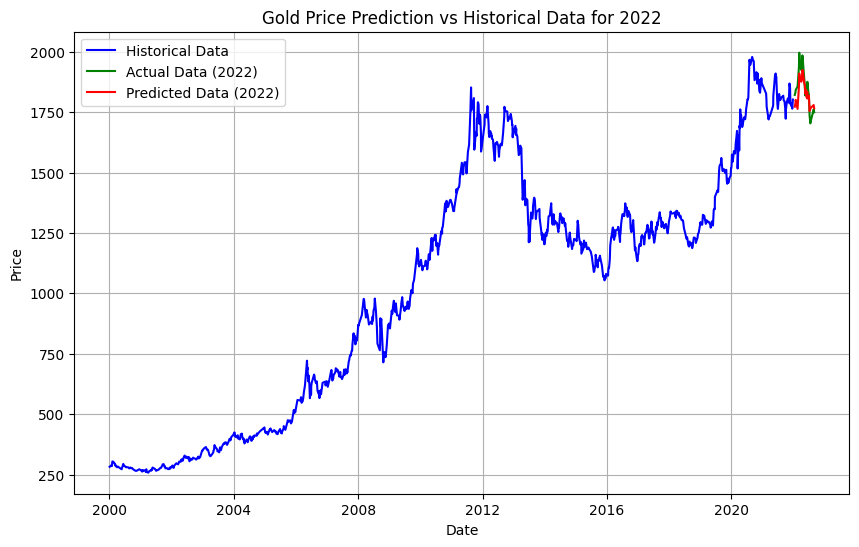

In [ ]:
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")

# Check that the pca_features column exists
df.select("pca_features").show(5)

# Ensure the correct column name when using the regression models
regression_models = [
    ("Linear Regression", LinearRegression(featuresCol="pca_features", labelCol="Close")),

]

# Hyperparameter tuning and Cross-Validation
regression_results = []
for model_name, model in regression_models:
    if model_name == "Linear Regression":
        # Linear Regression doesn't have maxDepth or numTrees, so we can tune other parameters
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()

    # Set up CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse"),
                              numFolds=5)

    # Train the model using CrossValidator
    cv_model = crossval.fit(train_df)

    # Best model
    best_model = cv_model.bestModel

    # Predict on test set
    predictions = best_model.transform(test_df)

# Visualizing the results
predictions_pd = predictions.select("Date", "Close", "prediction").toPandas()

# Ensure the Date column is in datetime format
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Filter historical data and predictions for 2022
historical_data = predictions_pd[predictions_pd['Date'].dt.year != 2022]  # Historical data excluding 2022
Actual_2022 = predictions_pd[predictions_pd['Date'].dt.year == 2022]  # 2022 actual data
predicted_2022 = predictions_pd[predictions_pd['Date'].dt.year == 2022]  # 2022 prediction data

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(historical_data['Date'], historical_data['Close'], label='Historical Data', color='blue')
plt.plot(Actual_2022['Date'], Actual_2022['Close'], label='Actual Data (2022)', color='green')
plt.plot(predicted_2022['Date'], predicted_2022['prediction'], label='Predicted Data (2022)', color='red')
plt.title('Gold Price Prediction vs Historical Data for 2022')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


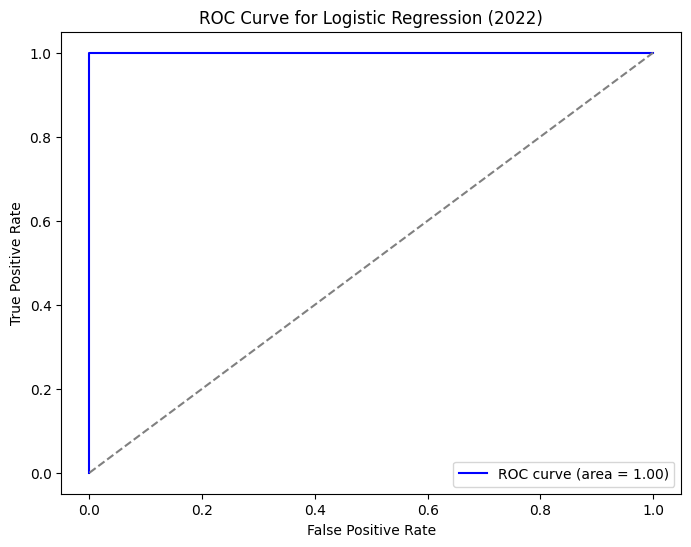

Model: Logistic Regression
Test Accuracy (2022): 1.0
Confusion Matrix:
[[13  0]
 [ 0 14]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27




In [ ]:
# Check if pca_features column already exists
if "pca_features" in df.columns:
    df = df.drop("pca_features")

# Apply PCA for dimensionality reduction (optional)
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)
df = pca_model.transform(df)

# Split the dataset into training and testing sets (80% train, 20% test)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Define the classification models (predicting increase or decrease)
df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))  # Label 1 for increase, 0 for decrease

# Split the dataset again for classification (80% train, 20% test)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Filter out data for 2022 for evaluation (this ensures the same train data is used for model training)
test_df_2022 = test_df.filter((test_df["Date"].substr(1, 4) == "2022"))

# Filter training data for all other years (this should remain the same as before)
train_df_non_2022 = train_df.filter((train_df["Date"].substr(1, 4) != "2022"))

classification_models = [
    ("Logistic Regression", LogisticRegression(featuresCol="pca_features", labelCol="Label")),
]

# Hyperparameter tuning and Cross-Validation
classification_results = []

# Store ROC data for plotting
roc_data = []

for model_name, model in classification_models:
    if model_name == "Logistic Regression":
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()

    # Set up CrossValidator using the training dataset (train_df_non_2022)
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy"),
                              numFolds=5)

    # Train the model using CrossValidator
    cv_model = crossval.fit(train_df_non_2022)

    # Best model
    best_model = cv_model.bestModel

    # Predict on test set (test_df_2022)
    predictions = best_model.transform(test_df_2022)

    # Evaluate accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    # Confusion Matrix and Classification Report
    y_true = predictions.select("Label").rdd.flatMap(lambda x: x).collect()
    y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    # Convert predictions to binary labels
    y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

    cm = confusion_matrix(y_true, y_pred_binary)
    clf_report = classification_report(y_true, y_pred_binary)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)
    roc_auc = auc(fpr, tpr)

    classification_results.append({
        'Model': model_name,
        'Test Accuracy (2022)': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': clf_report,
        'ROC AUC': roc_auc,
    })

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Logistic Regression (2022)')
    plt.legend(loc='lower right')
    plt.show()

# Print the classification results
for result in classification_results:
    print(f"Model: {result['Model']}")
    print(f"Test Accuracy (2022): {result['Test Accuracy (2022)']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Classification Report:\n{result['Classification Report']}\n")

spark.stop()


In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Estimator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Initialize Spark session with memory configuration
spark = SparkSession.builder \
    .appName("GoldPricePrediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Load and preprocess the dataset
try:
    df = spark.read.csv("gold1.csv", header=True, inferSchema=True)
    if df.count() == 0:
        print("Warning: Dataframe is empty.")
    else:
        print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Ensure the column "DailyChange%" exists before proceeding
if "DailyChange%" in df.columns:

# Feature engineering: Map days of the week to numerical values
    day_mapping = {
        "Monday": 0,
        "Tuesday": 1,
        "Wednesday": 2,
        "Thursday": 3,
        "Friday": 4,
        "Saturday": 5,
        "Sunday": 6
    }

    def map_day_to_index(day):
        return day_mapping.get(day, -1)

    map_day_udf = udf(map_day_to_index, IntegerType())
    df = df.withColumn("DayOfWeek_index", map_day_udf(df["DayOfWeek"]))

    # Now create the "Label" column
    df = df.withColumn("Label", (df["DailyChange%"] > 0).cast("double"))

else:
    print("Error: 'DailyChange%' column not found in the dataset.")

# Feature assembler
feature_cols = ["Open", "High", "Low", "Volume", "PriceRange", "LogReturn", "DailyChange%", "ShortMA", "LongMA", "Volatility", "DayOfWeek_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df)
df = pca_model.transform(df)

# Split the dataset into training and testing sets (80% train, 20% test)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ------------------- PREDICTION (Regression Task) -------------------
regression_models = [
    ("Linear Regression", LinearRegression(featuresCol="pca_features", labelCol="Close")),
    ("Random Forest Regressor", RandomForestRegressor(featuresCol="pca_features", labelCol="Close")),
    ("Decision Tree Regressor", DecisionTreeRegressor(featuresCol="pca_features", labelCol="Close"))
]

def run_regression_models():
    regression_results = []
    for model_name, model in regression_models:
        # Hyperparameter tuning for each model
        param_grid = get_regression_param_grid(model, model_name)

        # Cross-validation
        crossval = CrossValidator(estimator=model,
                                  estimatorParamMaps=param_grid,
                                  evaluator=RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse"),
                                  numFolds=5)

        # Train and evaluate the model
        cv_model = crossval.fit(train_df)
        best_model = cv_model.bestModel
        predictions = best_model.transform(test_df)

        # Evaluate RMSE and R²
        evaluator_rmse = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
        evaluator_r2 = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")

        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)

        regression_results.append({
            'Model': model_name,
            'RMSE': rmse,
            'R²': r2,
        })

    return regression_results

def get_regression_param_grid(model, model_name):
    if model_name == "Linear Regression":
        return ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()
    elif model_name == "Random Forest Regressor":
        return ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.numTrees, [10, 20]) \
            .build()
    elif model_name == "Decision Tree Regressor":
        return ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

# ------------------- CLASSIFICATION (Classification Task) -------------------
def prepare_classification_data(df):
    return df.randomSplit([0.8, 0.2], seed=42)

def run_classification_models(train_df, test_df):
    classification_models = [
        ("Logistic Regression", LogisticRegression(featuresCol="pca_features", labelCol="Label")),
        ("Random Forest Classifier", RandomForestClassifier(featuresCol="pca_features", labelCol="Label")),
        ("Decision Tree Classifier", DecisionTreeClassifier(featuresCol="pca_features", labelCol="Label"))
    ]

    classification_results = []

    for model_name, model in classification_models:
        # Hyperparameter tuning for each model
        param_grid = get_classification_param_grid(model, model_name)

        # Cross-validation
        crossval = CrossValidator(estimator=model,
                                  estimatorParamMaps=param_grid,
                                  evaluator=MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy"),
                                  numFolds=5)

        # Train and evaluate the model
        cv_model = crossval.fit(train_df)
        best_model = cv_model.bestModel
        predictions = best_model.transform(test_df)

        # Evaluate accuracy
        evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)

        # Confusion Matrix and Classification Report
        y_true = predictions.select("Label").rdd.flatMap(lambda x: x).collect()
        y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

        y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
        cm = confusion_matrix(y_true, y_pred_binary)
        clf_report = classification_report(y_true, y_pred_binary)

        classification_results.append({
            'Model': model_name,
            'Test Accuracy': accuracy,
            'Confusion Matrix': cm,
            'Classification Report': clf_report,
        })

    return classification_results

def get_classification_param_grid(model, model_name):
    if model_name == "Logistic Regression":
        return ParamGridBuilder() \
            .addGrid(model.regParam, [0.1, 0.01]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
            .build()
    elif model_name == "Random Forest Classifier":
        return ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .addGrid(model.numTrees, [10, 20]) \
            .build()
    elif model_name == "Decision Tree Classifier":
        return ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(predictions, model_name, label_col="Label"):
    get_class_1_probability_udf = udf(lambda probability: float(probability[1]), DoubleType())
    predictions = predictions.withColumn("probability_class_1", get_class_1_probability_udf(predictions["probability"]))

    y_true = predictions.select(label_col).rdd.flatMap(lambda x: x).collect()
    y_pred_prob = predictions.select("probability_class_1").rdd.flatMap(lambda x: x).collect()

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

def display_results(regression_results, classification_results):
    # Display regression results
    print("REGRESSION RESULTS")
    for result in regression_results:
        print(f"Regression Model: {result['Model']}")
        print(f"RMSE: {result['RMSE']}")
        print(f"R²: {result['R²']}")
        print("=" * 50)

    # Display classification results
    print("CLASSIFICATION RESULTS")
    for result in classification_results:
        print(f"Classification Model: {result['Model']}")
        print(f"Test Accuracy: {result['Test Accuracy']}")
        print(f"Confusion Matrix: \n{result['Confusion Matrix']}")
        print(f"Classification Report: \n{result['Classification Report']}")
        print("=" * 50)

# Run regression models and print results
regression_results = run_regression_models()
display_results(regression_results, [])

# Prepare classification data and run classification models, then print results
train_df, test_df = prepare_classification_data(df)
classification_results = run_classification_models(train_df, test_df)
display_results([], classification_results)

spark.stop()


Dataset loaded successfully.
REGRESSION RESULTS
Regression Model: Linear Regression
RMSE: 34.396094218030576
R²: 0.9953238735355737
Regression Model: Random Forest Regressor
RMSE: 52.454497561628884
R²: 0.9891248951914143
Regression Model: Decision Tree Regressor
RMSE: 55.185289374089685
R²: 0.9879631004411628
CLASSIFICATION RESULTS
REGRESSION RESULTS
CLASSIFICATION RESULTS
Classification Model: Logistic Regression
Test Accuracy: 0.9945155393053017
Confusion Matrix: 
[[517   2]
 [  4 571]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       519
         1.0       1.00      0.99      0.99       575

    accuracy                           0.99      1094
   macro avg       0.99      0.99      0.99      1094
weighted avg       0.99      0.99      0.99      1094

Classification Model: Random Forest Classifier
Test Accuracy: 0.9899451553930531
Confusion Matrix: 
[[515   4]
 [  7 568]]
Classification Report: 
       